# Deep Reinforcement Learning _in Action_
### Chapter 6
#### Evolutionary Strategies

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym

Creating an Agent

In [21]:
env = gym.make('CartPole-v1')

/Users/brandonbrown/anaconda3/envs/deeprl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [2]:
def init_random_agent_weights(state_space=4, action_space=2):
    return [
        torch.rand(state_space, 10), # fc1 weights
        torch.rand(10),  # fc1 bias
        torch.rand(10, 10),  # fc2 weights
        torch.rand(10),  # fc2 bias
        torch.rand(10, action_space),  # fc3 weights
        torch.rand(action_space),  # fc3 bias
    ]

def get_action_from_agent_weights(agent_weight, state):
    x = F.relu(torch.add(torch.mm(torch.Tensor(state.reshape(1,-1)), agent_weight[0]), agent_weight[1]))
    x = F.relu(torch.add(torch.mm(x, agent_weight[2]), agent_weight[3]))
    act_prob = F.softmax(torch.add(torch.mm(x, agent_weight[4]), agent_weight[5])).detach().numpy()[0]
    action = np.random.choice(range(len(act_prob)), p=act_prob)
    return action

Determining the Agent Fitness

In [3]:
def get_fitness(env, agent_weights, max_episode_length=500, trials=5):
    total_reward = 0
    for _ in range(trials):
        observation = env.reset()
        for i in range(max_episode_length):
            action = get_action_from_agent_weights(agent_weights, observation)
            observation, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
    return total_reward / trials


Cross

In [4]:
def cross(agent1_weights, agent2_weights):
    num_params = len(agent1_weights)
    crossover_idx = np.random.randint(0, num_params)
    new_weights = agent1_weights[:crossover_idx] + agent2_weights[crossover_idx:]
    new_weights = mutate(new_weights)
    return new_weights

Mutate

In [5]:
def mutate(new_weights):
    num_params = len(new_weights)
    num_params_to_update = np.random.randint(0, num_params)  # num of params to change
    for i in range(num_params_to_update):
        n = np.random.randint(0, num_params)
        new_weights[n] = new_weights[n] + torch.rand(new_weights[n].size())
    return new_weights

In [6]:
def breed(agent1_weights, agent2_weight, generation_size=10):
    next_generation = [agent1_weights, agent2_weight]
    for _ in range(generation_size - 2):
        next_generation.append(cross(agent1_weights, agent2_weight))
    return next_generation

def reproduce(env, agents_weights, generation_size):
    top_agents_weights = sorted(agents_weights, reverse=True, key=lambda a: get_fitness(env, a))[:2]
    new_agents_weights = breed(top_agents_weights[0], top_agents_weights[1], generation_size)
    return new_agents_weights

In [ ]:
n_generations = 100
generation_size = 20
generation_fitness = []
max_fitness = 0

agents = [init_random_agent_weights(), init_random_agent_weights()]

for i in range(n_generations):
    next_generation = reproduce(env, agents, generation_size)
    ranked_generation = sorted([get_fitness(env, a) for a in next_generation], reverse=True)
    avg_fitness = (ranked_generation[0] + ranked_generation[1]) / 2
    print(i, avg_fitness)
    generation_fitness.append(avg_fitness)
    agents = next_generation

### Plot loss

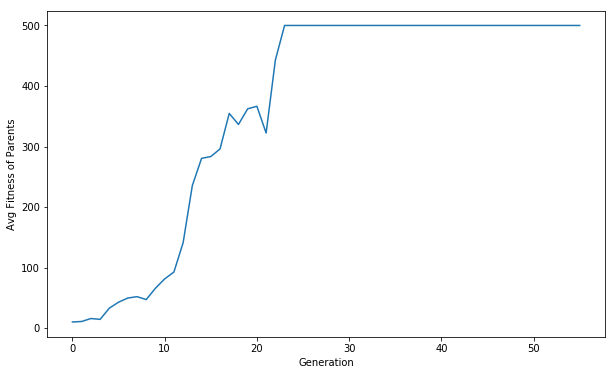

In [8]:
plt.figure(figsize=(10,6))
plt.ylabel("Avg Fitness of Parents")
plt.xlabel("Generation")
plt.plot(generation_fitness)

### Test trained agent

In [22]:
state = torch.from_numpy(env.reset()).float()
done = False
for i in range(200):
    action = get_action_from_agent_weights(agents[0],state)
    state, reward, done, info = env.step(action)
    state = torch.from_numpy(state).float()
    if done:
        print("Game over at time step {}".format(i,))
        break
    env.render()
env.close()

/Users/brandonbrown/anaconda3/envs/deeprl/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
